# **Ödevi Yapanlar**
Tuba SARIKAYA - 22060374

Zeynep Ravza DURSUN - 22060385

# K-Means Kümeleme Analizi Ödevi  

## Gerekli Kütüphanelerin İçe Aktarılması

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.datasets import load_iris

## Bölüm 1 - Wine Veri Seti, Train/Test Ayrımı ve Normalizasyon

### 1.1 Wine Veri Setinin Yüklenmesi

In [ ]:
# Wine veri setini yükle
wine = load_wine()
X = wine.data
y = wine.target

# Temel istatistikler
print("=" * 50)
print("WINE VERİ SETİ İSTATİSTİKLERİ")
print("=" * 50)
print(f"Örnek sayısı: {X.shape[0]}")
print(f"Öznitelik sayısı: {X.shape[1]}")
print(f"Sınıf sayısı: {len(np.unique(y))}")
print(f"Sınıf dağılımı: {np.bincount(y)}")
print("=" * 50)

WINE VERİ SETİ İSTATİSTİKLERİ
Örnek sayısı: 178
Öznitelik sayısı: 13
Sınıf sayısı: 3
Sınıf dağılımı: [59 71 48]


### 1.2 Veri Setinin %80 Train - %20 Test Olarak Ayrılması

In [ ]:
# %80 train - %20 test ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y  # Sınıf dağılımını korumak için
)

# Alt kümelerin boyutları
print("=" * 50)
print("TRAIN/TEST AYRIM BİLGİLERİ")
print("=" * 50)
print(f"X_train boyutu: {X_train.shape}")
print(f"X_test boyutu: {X_test.shape}")
print(f"y_train boyutu: {y_train.shape}")
print(f"y_test boyutu: {y_test.shape}")
print(f"\nTrain sınıf dağılımı: {np.bincount(y_train)}")
print(f"Test sınıf dağılımı: {np.bincount(y_test)}")
print("=" * 50)

TRAIN/TEST AYRIM BİLGİLERİ
X_train boyutu: (142, 13)
X_test boyutu: (36, 13)
y_train boyutu: (142,)
y_test boyutu: (36,)

Train sınıf dağılımı: [47 57 38]
Test sınıf dağılımı: [12 14 10]


### 1.3 Normalizasyon / Standardizasyon

In [ ]:
def normalize_data(X_train, X_test):
    """
    Z-score normalizasyonu: x' = (x - μ) / σ

    Parameters:
    -----------
    X_train : array, eğitim verisi
    X_test : array, test verisi

    Returns:
    --------
    X_train_norm, X_test_norm : normalize edilmiş veriler
    mu : ortalama değerler
    sigma : standart sapma değerleri
    """
    # Train verisinden ortalama ve standart sapma hesaplanması
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis=0)

    # Normalizasyon uygulanması
    X_train_norm = (X_train - mu) / sigma
    X_test_norm = (X_test - mu) / sigma

    return X_train_norm, X_test_norm, mu, sigma


# Normalizasyonun uygulanması
X_train_norm, X_test_norm, mu, sigma = normalize_data(X_train, X_test)

print("=" * 50)
print("NORMALİZASYON DOĞRULAMA")
print("=" * 50)
print("X_train_norm istatistikleri:")
print(f"Mean: {np.mean(X_train_norm, axis=0).round(3)}")
print(f"Std: {np.std(X_train_norm, axis=0).round(3)}")
print("\nX_test_norm istatistikleri:")
print(f"Mean: {np.mean(X_test_norm, axis=0).round(3)}")
print(f"Std: {np.std(X_test_norm, axis=0).round(3)}")
print("=" * 50)

NORMALİZASYON DOĞRULAMA
X_train_norm istatistikleri:
Mean: [ 0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0. -0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

X_test_norm istatistikleri:
Mean: [ 0.18  -0.016  0.031 -0.191  0.036  0.171  0.229  0.071 -0.08   0.145
  0.185  0.039  0.122]
Std: [1.047 1.073 1.109 0.926 0.762 1.027 1.21  1.203 0.936 0.959 1.032 1.141
 1.202]


## Bölüm 2 - Wine için K-Means, Elbow ve Silhouette (Normalizasyonlu)

### 2.1 Küme Sayısı Aralığının Belirlenmesi

In [ ]:
# Gerçek sınıf sayısı
k_true = len(np.unique(y_train))
n_train = X_train_norm.shape[0]

# Küme sayısı aralığı
k_min = 2
k_max = k_true + int(np.floor(np.log(n_train)))

print("=" * 50)
print("KÜME SAYISI ARALIĞI")
print("=" * 50)
print(f"Gerçek sınıf sayısı (k_true): {k_true}")
print(f"Train örnek sayısı (n_train): {n_train}")
print(f"k_min: {k_min}")
print(f"k_max: {k_max}")
print(f"Deneyeceğimiz k değerleri: {list(range(k_min, k_max + 1))}")
print("=" * 50)

KÜME SAYISI ARALIĞI
Gerçek sınıf sayısı (k_true): 3
Train örnek sayısı (n_train): 142
k_min: 2
k_max: 7
Deneyeceğimiz k değerleri: [2, 3, 4, 5, 6, 7]


### 2.2 K-Means Algoritmasının Açık Biçimde Yazılması (my_kmeans)

In [ ]:
def my_kmeans(X, k, max_iter=300, random_state=42):
    """
    K-Means kümeleme algoritması (manuel implementasyon)

    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
    k : int, küme sayısı
    max_iter : int, maksimum iterasyon sayısı
    random_state : int, rastgelelik için seed

    Returns:
    --------
    labels : array, her örneğin küme etiketi
    centers : array, küme merkezleri
    inertia : float, toplam uzaklık karesi (within-cluster sum of squares)
    """
    np.random.seed(random_state)
    n_samples, n_features = X.shape

    # 1. Rastgele k örneğinin başlangıç merkezi olarak seçilmesi
    random_indices = np.random.choice(n_samples, k, replace=False)
    centers = X[random_indices].copy()

    for iteration in range(max_iter):
        # 2. Her örneğin en yakın merkeze atanması
        # Mesafe matrisinin hesaplanması (n_samples, k)
        distances = np.zeros((n_samples, k))
        for i in range(k):
            distances[:, i] = np.sum((X - centers[i])**2, axis=1)

        # En yakın merkezin bulunması
        labels = np.argmin(distances, axis=1)

        # 3. Yeni merkezlerin hesaplanması
        new_centers = np.zeros((k, n_features))
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = np.mean(cluster_points, axis=0)
            else:
                # Eğer küme boşsa, rastgele bir nokta seçilmesi
                new_centers[i] = X[np.random.choice(n_samples)]

        # 4. Yakınsama kontrolü (merkezler değişmedi mi?)
        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    # 5. Inertia hesaplanması
    inertia = 0.0
    for i in range(k):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centers[i])**2)

    return labels, centers, inertia


# Test (k=3 için)
labels_test, centers_test, inertia_test = my_kmeans(X_train_norm, k=3)

print("=" * 50)
print("MY_KMEANS TESTİ (k=3)")
print("=" * 50)
print(f"Küme etiketleri: {labels_test[:10]}...")
print(f"Küme merkezleri shape: {centers_test.shape}")
print(f"Inertia: {inertia_test:.4f}")
print(f"Her kümedeki örnek sayısı: {np.bincount(labels_test)}")
print("=" * 50)

MY_KMEANS TESTİ (k=3)
Küme etiketleri: [1 1 1 1 0 0 1 0 1 1]...
Küme merkezleri shape: (3, 13)
Inertia: 1016.0214
Her kümedeki örnek sayısı: [41 51 50]


### 2.3 Silhouette Skorunun Açık Biçimde Yazılması (my_silhouette_score)

In [ ]:
def my_silhouette_score(X, labels):
    """
    Silhouette skoru hesaplama (manuel implementasyon)

    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
    labels : array, küme etiketleri

    Returns:
    --------
    silhouette_avg : float, ortalama silhouette skoru
    """
    n_samples = X.shape[0]
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Tek küme varsa silhouette tanımsız
    if n_clusters == 1:
        return 0.0

    silhouette_scores = np.zeros(n_samples)

    for i in range(n_samples):
        # i'nin ait olduğu küme
        cluster_i = labels[i]

        # a(i): Kendi kümesindeki diğer noktalara ortalama uzaklık
        same_cluster_mask = (labels == cluster_i)
        same_cluster_points = X[same_cluster_mask]

        if len(same_cluster_points) > 1:
            # Kendisi hariç diğer noktalara uzaklık
            distances_same = np.sum((same_cluster_points - X[i])**2, axis=1)**0.5
            a_i = np.sum(distances_same) / (len(same_cluster_points) - 1)
        else:
            # Kümede tek başınaysa a(i) = 0
            a_i = 0.0

        # b(i): Diğer kümelere olan minimum ortalama uzaklık
        b_i = np.inf
        for cluster_j in unique_labels:
            if cluster_j != cluster_i:
                other_cluster_mask = (labels == cluster_j)
                other_cluster_points = X[other_cluster_mask]

                # Bu kümedeki noktalara ortalama uzaklık
                distances_other = np.sum((other_cluster_points - X[i])**2, axis=1)**0.5
                avg_distance_to_cluster = np.mean(distances_other)

                # Minimum olanı tut
                if avg_distance_to_cluster < b_i:
                    b_i = avg_distance_to_cluster

        # s(i) hesapla
        if max(a_i, b_i) > 0:
            s_i = (b_i - a_i) / max(a_i, b_i)
        else:
            s_i = 0.0

        silhouette_scores[i] = s_i

    # Ortalama silhouette skoru
    silhouette_avg = np.mean(silhouette_scores)

    return silhouette_avg


# Test (k=3 için önceki sonuçla)
silhouette_test = my_silhouette_score(X_train_norm, labels_test)

print("=" * 50)
print("MY_SILHOUETTE_SCORE TESTİ (k=3)")
print("=" * 50)
print(f"Silhouette Score: {silhouette_test:.4f}")
print("=" * 50)

MY_SILHOUETTE_SCORE TESTİ (k=3)
Silhouette Score: 0.2851


### 2.4 Elbow ve Silhouette Grafiklerinin Çizilmesi

ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonlu)
k=2 → Inertia: 1327.2896, Silhouette: 0.2670
k=3 → Inertia: 1016.0214, Silhouette: 0.2851
k=4 → Inertia: 956.9642, Silhouette: 0.2266
k=5 → Inertia: 921.6302, Silhouette: 0.2136
k=6 → Inertia: 842.8134, Silhouette: 0.2097
k=7 → Inertia: 787.8671, Silhouette: 0.1827


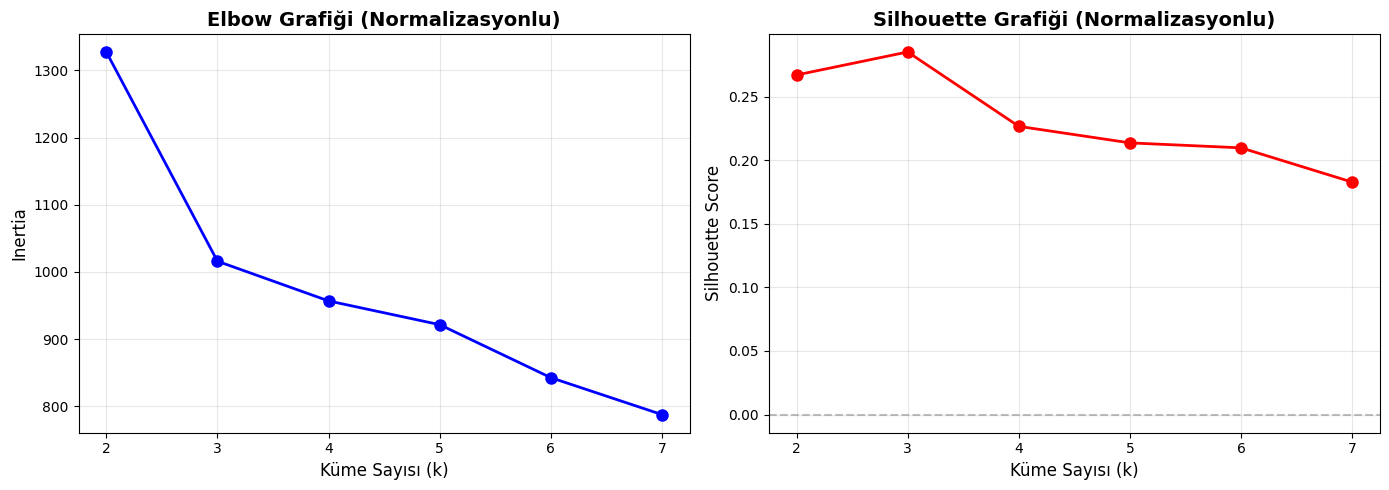

In [ ]:
# k = 2, ..., k_max için tüm değerlerin hesaplanması
k_values = range(k_min, k_max + 1)
inertia_values = []
silhouette_values = []

print("=" * 50)
print("ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonlu)")
print("=" * 50)

for k in k_values:
    # K-Means çalıştırılması
    labels, centers, inertia = my_kmeans(X_train_norm, k=k, random_state=42)

    # Silhouette hesaplanması
    silhouette = my_silhouette_score(X_train_norm, labels)

    # Kaydedilmesi
    inertia_values.append(inertia)
    silhouette_values.append(silhouette)

    print(f"k={k} → Inertia: {inertia:.4f}, Silhouette: {silhouette:.4f}")

print("=" * 50)

# Grafiklerin çizilmesi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow grafiği
ax1.plot(k_values, inertia_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Grafiği (Normalizasyonlu)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)

# Silhouette grafiği
ax2.plot(k_values, silhouette_values, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Grafiği (Normalizasyonlu)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Bölüm 3 - Wine için K-Means, Elbow ve Silhouette (Normalizasyonsuz)

### 3.1 Normalizasyonsuz Eğitim Verisi ile Analiz

ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonsuz)
k=2 → Inertia: 3171040.8319, Silhouette: 0.6533
k=3 → Inertia: 1525470.0582, Silhouette: 0.5879
k=4 → Inertia: 896061.2711, Silhouette: 0.5600
k=5 → Inertia: 642755.0536, Silhouette: 0.4985
k=6 → Inertia: 421637.9062, Silhouette: 0.5455
k=7 → Inertia: 351291.4916, Silhouette: 0.5324


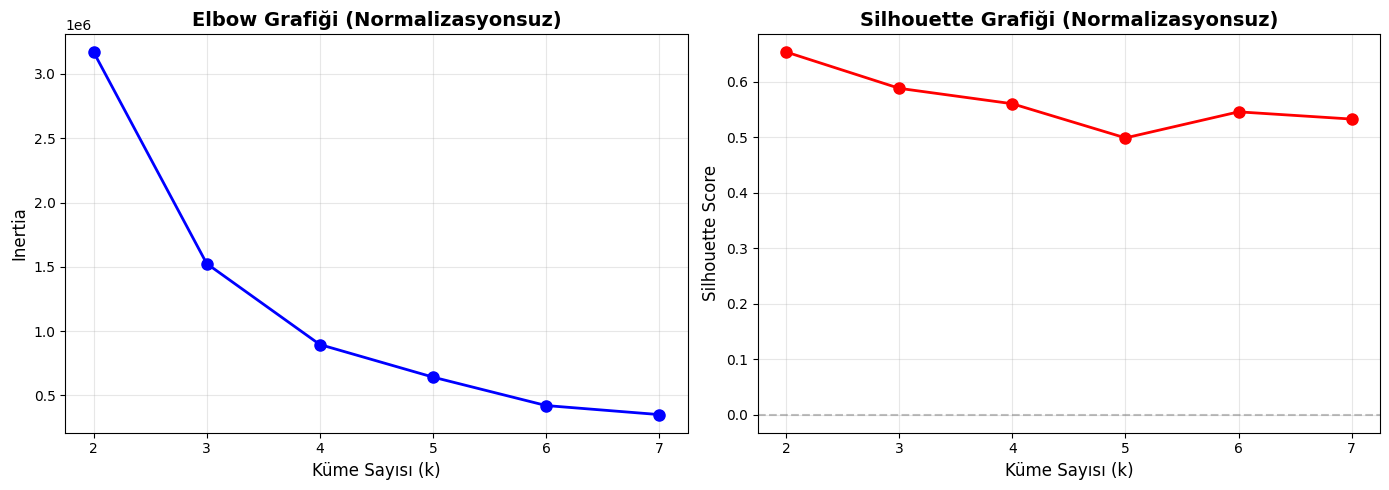

In [ ]:
# Ham (normalizasyonsuz) eğitim verisi ile aynı analizlerin tekrarlanması
k_values = range(k_min, k_max + 1)
inertia_values_raw = []
silhouette_values_raw = []

print("=" * 50)
print("ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonsuz)")
print("=" * 50)

for k in k_values:
    # K-Means çalıştırılması (ham veri üzerinde)
    labels, centers, inertia = my_kmeans(X_train, k=k, random_state=42)

    # Silhouette hesaplanması
    silhouette = my_silhouette_score(X_train, labels)

    # Kaydedilmesi
    inertia_values_raw.append(inertia)
    silhouette_values_raw.append(silhouette)

    print(f"k={k} → Inertia: {inertia:.4f}, Silhouette: {silhouette:.4f}")

print("=" * 50)

# Grafiklerin çizilmesi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow grafiği
ax1.plot(k_values, inertia_values_raw, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Grafiği (Normalizasyonsuz)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)

# Silhouette grafiği
ax2.plot(k_values, silhouette_values_raw, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Grafiği (Normalizasyonsuz)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 3.2 Normalizasyonun Etkisinin Karşılaştırılması

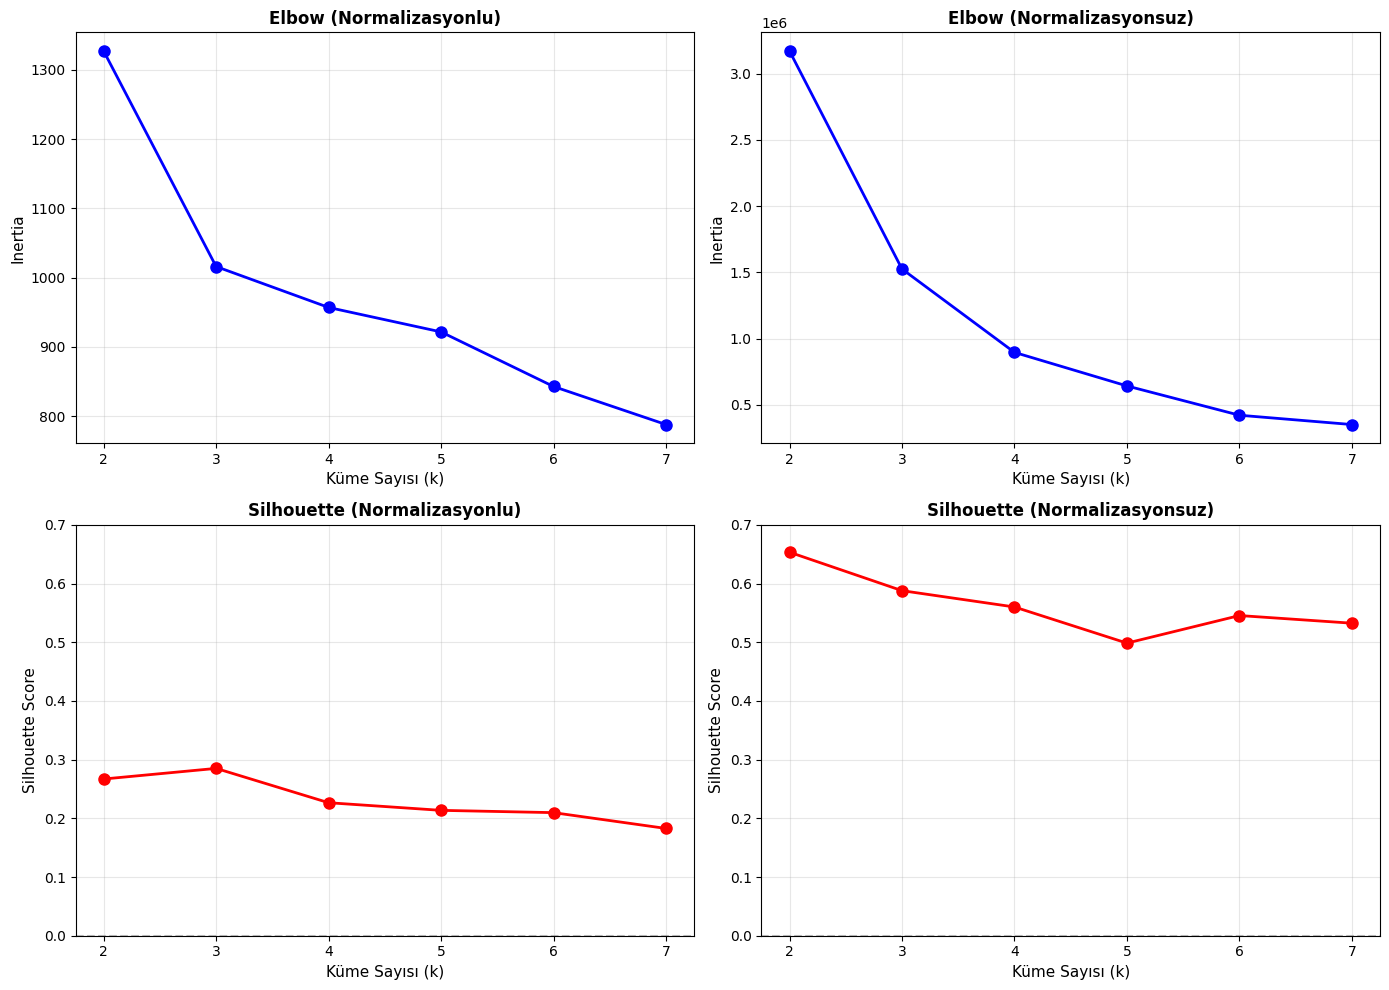

In [ ]:
# Karşılaştırma grafikleri
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow - Normalizasyonlu
axes[0, 0].plot(k_values, inertia_values, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[0, 0].set_ylabel('Inertia', fontsize=11)
axes[0, 0].set_title('Elbow (Normalizasyonlu)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_values)

# Elbow - Normalizasyonsuz
axes[0, 1].plot(k_values, inertia_values_raw, 'bo-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[0, 1].set_ylabel('Inertia', fontsize=11)
axes[0, 1].set_title('Elbow (Normalizasyonsuz)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_values)

# Silhouette - Normalizasyonlu
axes[1, 0].plot(k_values, silhouette_values, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[1, 0].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 0].set_title('Silhouette (Normalizasyonlu)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_values)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_ylim([0, 0.7])

# Silhouette - Normalizasyonsuz
axes[1, 1].plot(k_values, silhouette_values_raw, 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 1].set_title('Silhouette (Normalizasyonsuz)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values)
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_ylim([0, 0.7])

plt.tight_layout()
plt.show()

## **NORMALİZASYONUN K-MEANS KÜMELEMESİNE ETKİSİ ANALİZİ**

### Sayısal Karşılaştırma (k=3 için)

| Metrik | Normalizasyonlu | Normalizasyonsuz | Fark |
|:-------|:---------------:|:----------------:|:----:|
| **Inertia** | 1,016.02 | 1,525,470.06 | **~1,500x** |
| **Silhouette Score** | 0.2851 | 0.5879 | **~2x** |
| **Önerilen k** | 3  | 2  | |

---

### **Temel Bulgular**

**1. Ölçek Problemi:**
Wine veri setinde öznitelikler arasında ~2,600x ölçek farkı var. Örneğin "proline" (278-1680) vs "ash" (1.36-3.23). Normalizasyon olmadan büyük ölçekli öznitelikler kümelemeyi tamamen domine ediyor.

**2. Yanıltıcı Silhouette Skoru:**
Normalizasyonsuz veride silhouette skoru (0.59) yüksek görünse de **yanıltıcıdır**. Büyük ölçekli öznitelikler yapay olarak yüksek skor üretiyor. Normalizasyonlu verideki 0.28 skoru daha **gerçekçi** ve **güvenilir**.

**3. Optimal k Seçimi:**
- **Normalizasyonlu:** k=3 (gerçek sınıf sayısı)
- **Normalizasyonsuz:** k=2 (yanlış öneri)

**4. Inertia Farkı:**
Normalizasyonsuz veride inertia 1,500 kat daha büyük. Bu, uzaklık hesaplamalarının tamamen büyük ölçekli öznitelikler tarafından belirlendiğini gösteriyor.

---

### Sonuç

 **Wine veri seti için NORMALİZASYON ZORUNLUDUR**

 Normalizasyon yapıldığında:
- Tüm öznitelikler eşit ağırlıkta
- Doğru küme sayısı bulunuyor (k=3)
- Güvenilir metrik değerleri elde ediliyor

 Normalizasyon yapılmadığında:
- Büyük ölçekli öznitelikler dominant
- Yanlış küme sayısı öneriliyor (k=2)
- Silhouette skoru yanıltıcı derecede yüksek

## Bölüm 4 - Wine için ARI ve NMI Analizi

### 4.1 K-Means Eğitimi ve Test Verisinin Kümelere Atanması

In [ ]:
def assign_clusters(X, centers):
    """
    Verilen merkez noktalarına göre örneklerin en yakın kümeye atanması

    Parameters:
    -----------
    X : array, atanacak veri
    centers : array, küme merkezleri

    Returns:
    --------
    labels : array, küme etiketleri
    """
    k = centers.shape[0]
    n_samples = X.shape[0]

    # Her örnek için en yakın merkezi bul
    distances = np.zeros((n_samples, k))
    for i in range(k):
        distances[:, i] = np.sum((X - centers[i])**2, axis=1)

    labels = np.argmin(distances, axis=1)
    return labels


# Test edelim (k=3 için)
# Önce eğitim verisinde K-Means'in çalıştırılması
labels_train, centers, inertia = my_kmeans(X_train_norm, k=3, random_state=42)

# Test verisinin aynı merkezlere göre atanması
labels_test = assign_clusters(X_test_norm, centers)

print("=" * 50)
print("K-MEANS EĞİTİMİ VE TEST ATAMASI (k=3)")
print("=" * 50)
print(f"Train labels shape: {labels_train.shape}")
print(f"Test labels shape: {labels_test.shape}")
print(f"Train küme dağılımı: {np.bincount(labels_train)}")
print(f"Test küme dağılımı: {np.bincount(labels_test)}")
print("=" * 50)

K-MEANS EĞİTİMİ VE TEST ATAMASI (k=3)
Train labels shape: (142,)
Test labels shape: (36,)
Train küme dağılımı: [41 51 50]
Test küme dağılımı: [10 13 13]


### 4.2 ARI'nin Açık Biçimde Yazılması (my_ari)

In [ ]:
def my_ari(y_true, y_pred):
    """
    Adjusted Rand Index (ARI) hesaplama (manuel implementasyon)
    Kontenjans tablosu üzerinden hesaplanır.

    Parameters:
    -----------
    y_true : array, gerçek etiketler
    y_pred : array, tahmin edilen küme etiketleri

    Returns:
    --------
    ari : float, Adjusted Rand Index değeri
    """
    # Kontenjans tablosunun oluşturulması
    classes = np.unique(y_true)
    clusters = np.unique(y_pred)

    n_classes = len(classes)
    n_clusters = len(clusters)
    n = len(y_true)

    # Kontenjans tablosu (contingency table)
    contingency = np.zeros((n_classes, n_clusters), dtype=int)

    for i, c in enumerate(classes):
        for j, k in enumerate(clusters):
            contingency[i, j] = np.sum((y_true == c) & (y_pred == k))

    # Satır ve sütun toplamları
    a = np.sum(contingency, axis=1)  # satır toplamları (ai)
    b = np.sum(contingency, axis=0)  # sütun toplamları (bj)

    # Kombinasyon fonksiyonu: C(n, 2) = n*(n-1)/2
    def comb2(n):
        return n * (n - 1) / 2

    # Index: Σ C(nij, 2)
    sum_comb_nij = np.sum(comb2(contingency))

    # ExpectedIndex: [Σ C(ai, 2)] * [Σ C(bj, 2)] / C(n, 2)
    sum_comb_a = np.sum(comb2(a))
    sum_comb_b = np.sum(comb2(b))
    expected_index = (sum_comb_a * sum_comb_b) / comb2(n) if comb2(n) > 0 else 0

    # MaxIndex: 1/2 * [Σ C(ai, 2) + Σ C(bj, 2)]
    max_index = 0.5 * (sum_comb_a + sum_comb_b)

    # ARI hesaplanması
    if max_index - expected_index == 0:
        ari = 0
    else:
        ari = (sum_comb_nij - expected_index) / (max_index - expected_index)

    return ari


# Test (k=3 için train ve test)
ari_train = my_ari(y_train, labels_train)
ari_test = my_ari(y_test, labels_test)

print("=" * 50)
print("MY_ARI TESTİ (k=3)")
print("=" * 50)
print(f"ARI (Train): {ari_train:.4f}")
print(f"ARI (Test): {ari_test:.4f}")

MY_ARI TESTİ (k=3)
ARI (Train): 0.8511
ARI (Test): 0.9088


### 4.3 NMI Hesabı

In [ ]:
# NMI hesabı (k=3 için test)
nmi_train = normalized_mutual_info_score(y_train, labels_train)
nmi_test = normalized_mutual_info_score(y_test, labels_test)

print("=" * 50)
print("NMI TESTİ (k=3)")
print("=" * 50)
print(f"NMI (Train): {nmi_train:.4f}")
print(f"NMI (Test): {nmi_test:.4f}")

NMI TESTİ (k=3)
NMI (Train): 0.8359
NMI (Test): 0.9092


### 4.4 ARI ve NMI Grafiklerinin Çizilmesi


ARI VE NMI ANALİZİ (Normalizasyonlu)
k=2 → ARI(train)=0.3944, ARI(test)=0.3701, NMI(train)=0.5100, NMI(test)=0.4957
k=3 → ARI(train)=0.8511, ARI(test)=0.9088, NMI(train)=0.8359, NMI(test)=0.9092
k=4 → ARI(train)=0.7464, ARI(test)=0.7456, NMI(train)=0.7524, NMI(test)=0.7642
k=5 → ARI(train)=0.7441, ARI(test)=0.6294, NMI(train)=0.7268, NMI(test)=0.7085
k=6 → ARI(train)=0.6040, ARI(test)=0.6608, NMI(train)=0.6732, NMI(test)=0.7918
k=7 → ARI(train)=0.5501, ARI(test)=0.6562, NMI(train)=0.6461, NMI(test)=0.7905


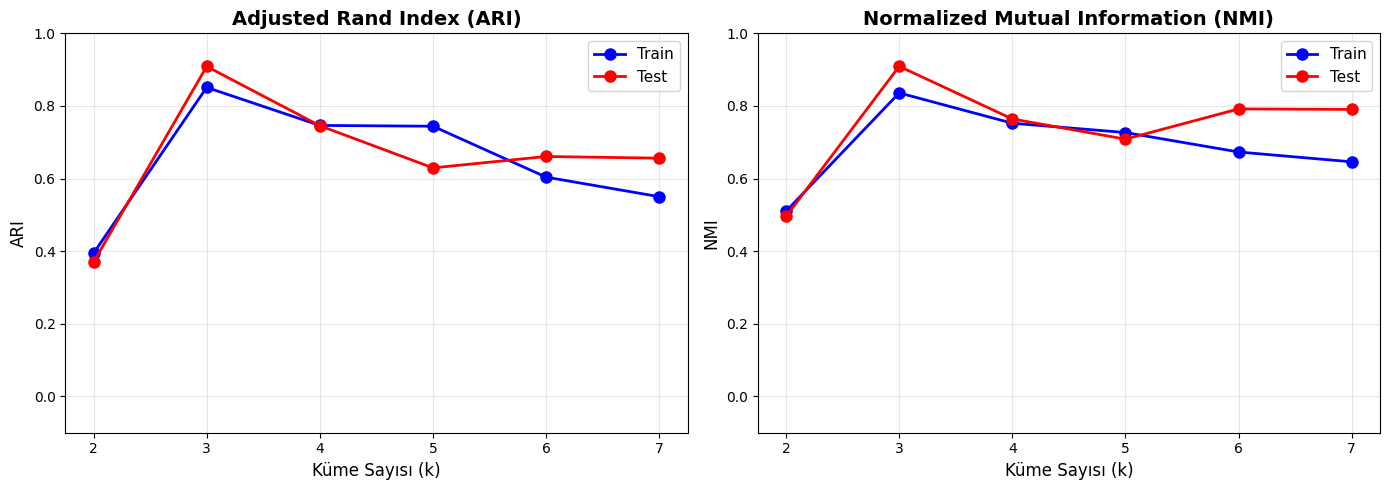

In [ ]:
# k = 2, ..., k_max için tüm değerlerin hesaplanması
k_values = range(k_min, k_max + 1)

ari_train_values = []
ari_test_values = []
nmi_train_values = []
nmi_test_values = []

print("\n" + "=" * 50)
print("ARI VE NMI ANALİZİ (Normalizasyonlu)")
print("=" * 50)

for k in k_values:
    # K-Means eğitimi (train)
    labels_train, centers, inertia = my_kmeans(X_train_norm, k=k, random_state=42)

    # Test verisini ata
    labels_test = assign_clusters(X_test_norm, centers)

    # ARI hesapla
    ari_train = my_ari(y_train, labels_train)
    ari_test = my_ari(y_test, labels_test)

    # NMI hesapla
    nmi_train = normalized_mutual_info_score(y_train, labels_train)
    nmi_test = normalized_mutual_info_score(y_test, labels_test)

    # Kaydet
    ari_train_values.append(ari_train)
    ari_test_values.append(ari_test)
    nmi_train_values.append(nmi_train)
    nmi_test_values.append(nmi_test)

    print(f"k={k} → ARI(train)={ari_train:.4f}, ARI(test)={ari_test:.4f}, "
          f"NMI(train)={nmi_train:.4f}, NMI(test)={nmi_test:.4f}")

print("=" * 50)

# Grafiklerin çizilmesi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ARI grafiği
ax1.plot(k_values, ari_train_values, 'bo-', linewidth=2, markersize=8, label='Train')
ax1.plot(k_values, ari_test_values, 'ro-', linewidth=2, markersize=8, label='Test')
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('ARI', fontsize=12)
ax1.set_title('Adjusted Rand Index (ARI)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)
ax1.set_ylim([-0.1, 1.0])

# NMI grafiği
ax2.plot(k_values, nmi_train_values, 'bo-', linewidth=2, markersize=8, label='Train')
ax2.plot(k_values, nmi_test_values, 'ro-', linewidth=2, markersize=8, label='Test')
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('NMI', fontsize=12)
ax2.set_title('Normalized Mutual Information (NMI)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values)
ax2.set_ylim([-0.1, 1.0])

plt.tight_layout()
plt.show()

## Bölüm 5 - Iris Veri Seti için Tüm Adımların Tekrarlanması

### 5.1 Iris Veri Seti: Yükleme, Train/Test Ayrımı, Normalizasyon ve Küme Sayısı Belirleme

In [ ]:
# Iris veri setinin yüklenmesi
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Temel istatistikler
print("=" * 50)
print("IRIS VERİ SETİ İSTATİSTİKLERİ")
print("=" * 50)
print(f"Örnek sayısı: {X_iris.shape[0]}")
print(f"Öznitelik sayısı: {X_iris.shape[1]}")
print(f"Sınıf sayısı: {len(np.unique(y_iris))}")
print(f"Sınıf dağılımı: {np.bincount(y_iris)}")
print("=" * 50)

# %80 train - %20 test ayrımı
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
    X_iris, y_iris,
    test_size=0.20,
    random_state=42,
    stratify=y_iris
)

print("\n" + "=" * 50)
print("TRAIN/TEST AYRIM BİLGİLERİ")
print("=" * 50)
print(f"X_iris_train boyutu: {X_iris_train.shape}")
print(f"X_iris_test boyutu: {X_iris_test.shape}")
print(f"y_iris_train boyutu: {y_iris_train.shape}")
print(f"y_iris_test boyutu: {y_iris_test.shape}")
print(f"\nTrain sınıf dağılımı: {np.bincount(y_iris_train)}")
print(f"Test sınıf dağılımı: {np.bincount(y_iris_test)}")
print("=" * 50)

# Normalizasyon
X_iris_train_norm, X_iris_test_norm, mu_iris, sigma_iris = normalize_data(X_iris_train, X_iris_test)

print("\n" + "=" * 50)
print("NORMALİZASYON DOĞRULAMA")
print("=" * 50)
print("X_iris_train_norm istatistikleri:")
print(f"Mean: {np.mean(X_iris_train_norm, axis=0).round(3)}")
print(f"Std: {np.std(X_iris_train_norm, axis=0).round(3)}")
print("=" * 50)

# Küme sayısı aralığı
k_true_iris = len(np.unique(y_iris_train))
n_train_iris = X_iris_train_norm.shape[0]
k_min_iris = 2
k_max_iris = k_true_iris + int(np.floor(np.log(n_train_iris)))

print("\n" + "=" * 50)
print("KÜME SAYISI ARALIĞI")
print("=" * 50)
print(f"Gerçek sınıf sayısı (k_true): {k_true_iris}")
print(f"Train örnek sayısı (n_train): {n_train_iris}")
print(f"k_min: {k_min_iris}")
print(f"k_max: {k_max_iris}")
print(f"Deneyeceğimiz k değerleri: {list(range(k_min_iris, k_max_iris + 1))}")
print("=" * 50)

IRIS VERİ SETİ İSTATİSTİKLERİ
Örnek sayısı: 150
Öznitelik sayısı: 4
Sınıf sayısı: 3
Sınıf dağılımı: [50 50 50]

TRAIN/TEST AYRIM BİLGİLERİ
X_iris_train boyutu: (120, 4)
X_iris_test boyutu: (30, 4)
y_iris_train boyutu: (120,)
y_iris_test boyutu: (30,)

Train sınıf dağılımı: [40 40 40]
Test sınıf dağılımı: [10 10 10]

NORMALİZASYON DOĞRULAMA
X_iris_train_norm istatistikleri:
Mean: [-0. -0.  0.  0.]
Std: [1. 1. 1. 1.]

KÜME SAYISI ARALIĞI
Gerçek sınıf sayısı (k_true): 3
Train örnek sayısı (n_train): 120
k_min: 2
k_max: 7
Deneyeceğimiz k değerleri: [2, 3, 4, 5, 6, 7]


### 5.2 Iris için K-Means, Elbow ve Silhouette Analizi

### 5.2.1 Normalizasyonlu Veri ile Analiz

IRIS - ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonlu)
k=2 → Inertia: 181.2279, Silhouette: 0.5759
k=3 → Inertia: 158.8850, Silhouette: 0.4758
k=4 → Inertia: 89.6663, Silhouette: 0.4201
k=5 → Inertia: 72.9770, Silhouette: 0.3502
k=6 → Inertia: 64.9205, Silhouette: 0.3408
k=7 → Inertia: 59.4813, Silhouette: 0.3314


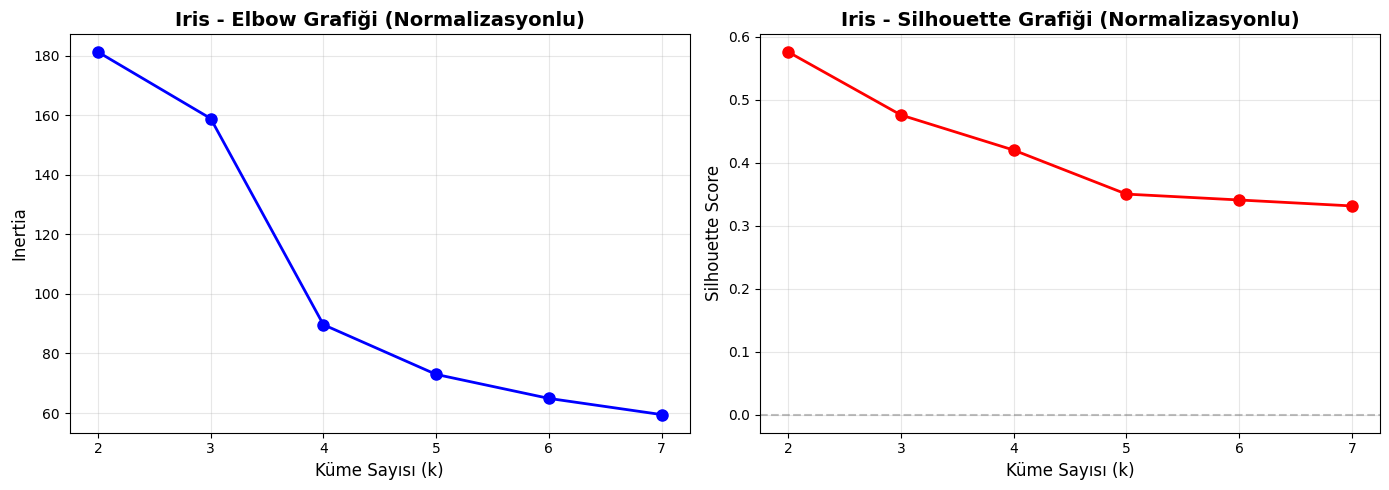

In [ ]:
# Normalizasyonlu Iris verisi ile analiz
k_values_iris = range(k_min_iris, k_max_iris + 1)
inertia_values_iris_norm = []
silhouette_values_iris_norm = []

print("=" * 50)
print("IRIS - ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonlu)")
print("=" * 50)

for k in k_values_iris:
    # K-Means çalıştırılması
    labels, centers, inertia = my_kmeans(X_iris_train_norm, k=k, random_state=42)

    # Silhouette hesaplanması
    silhouette = my_silhouette_score(X_iris_train_norm, labels)

    # Kaydedilmesi
    inertia_values_iris_norm.append(inertia)
    silhouette_values_iris_norm.append(silhouette)

    print(f"k={k} → Inertia: {inertia:.4f}, Silhouette: {silhouette:.4f}")

print("=" * 50)

# Grafiklerin çizilmesi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow grafiği
ax1.plot(k_values_iris, inertia_values_iris_norm, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Iris - Elbow Grafiği (Normalizasyonlu)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values_iris)

# Silhouette grafiği
ax2.plot(k_values_iris, silhouette_values_iris_norm, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Iris - Silhouette Grafiği (Normalizasyonlu)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values_iris)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 5.2.2 Normalizasyonsuz Veri ile Analiz


IRIS - ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonsuz)
k=2 → Inertia: 126.1251, Silhouette: 0.6839
k=3 → Inertia: 120.0710, Silhouette: 0.5336
k=4 → Inertia: 55.6823, Silhouette: 0.4391
k=5 → Inertia: 39.8356, Silhouette: 0.3750
k=6 → Inertia: 33.4512, Silhouette: 0.3422
k=7 → Inertia: 31.8082, Silhouette: 0.3307


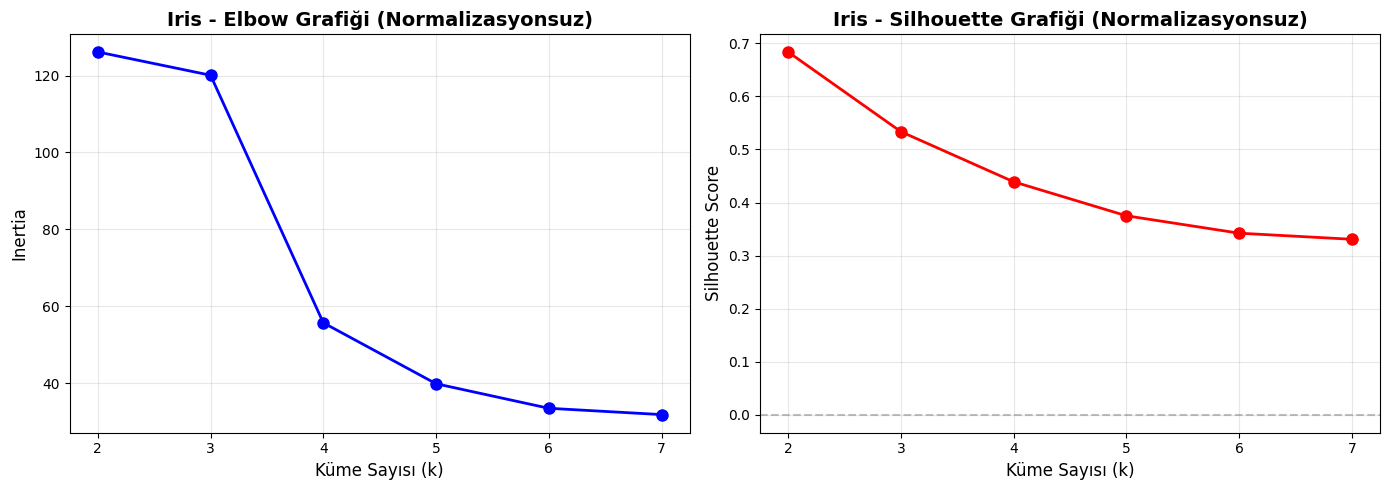

In [ ]:
# Normalizasyonsuz Iris verisi ile analiz
inertia_values_iris_raw = []
silhouette_values_iris_raw = []

print("\n" + "=" * 50)
print("IRIS - ELBOW VE SILHOUETTE ANALİZİ (Normalizasyonsuz)")
print("=" * 50)

for k in k_values_iris:
    # K-Means çalıştırılması (ham veri)
    labels, centers, inertia = my_kmeans(X_iris_train, k=k, random_state=42)

    # Silhouette hesaplanması
    silhouette = my_silhouette_score(X_iris_train, labels)

    # Kaydedilmesi
    inertia_values_iris_raw.append(inertia)
    silhouette_values_iris_raw.append(silhouette)

    print(f"k={k} → Inertia: {inertia:.4f}, Silhouette: {silhouette:.4f}")

print("=" * 50)

# Grafiklerin çizilmesi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow grafiği
ax1.plot(k_values_iris, inertia_values_iris_raw, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Iris - Elbow Grafiği (Normalizasyonsuz)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values_iris)

# Silhouette grafiği
ax2.plot(k_values_iris, silhouette_values_iris_raw, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Iris - Silhouette Grafiği (Normalizasyonsuz)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values_iris)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 5.2.3 Normalizasyon Etkisinin Karşılaştırılması (Iris)

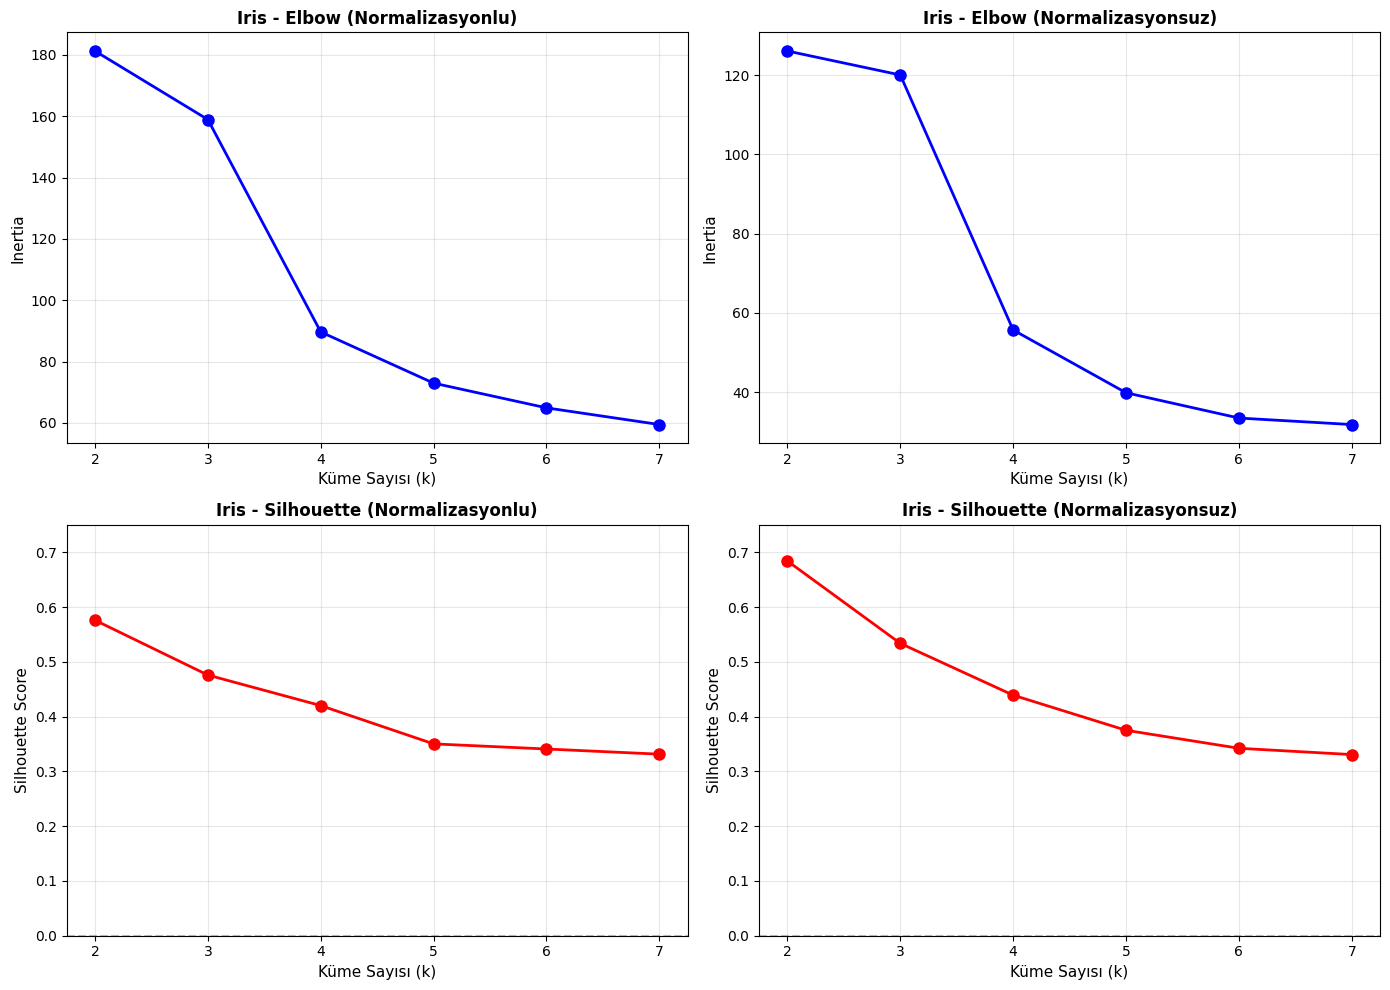

In [ ]:
# Karşılaştırma grafikleri
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow - Normalizasyonlu
axes[0, 0].plot(k_values_iris, inertia_values_iris_norm, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[0, 0].set_ylabel('Inertia', fontsize=11)
axes[0, 0].set_title('Iris - Elbow (Normalizasyonlu)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_values_iris)

# Elbow - Normalizasyonsuz
axes[0, 1].plot(k_values_iris, inertia_values_iris_raw, 'bo-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[0, 1].set_ylabel('Inertia', fontsize=11)
axes[0, 1].set_title('Iris - Elbow (Normalizasyonsuz)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_values_iris)

# Silhouette - Normalizasyonlu
axes[1, 0].plot(k_values_iris, silhouette_values_iris_norm, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[1, 0].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 0].set_title('Iris - Silhouette (Normalizasyonlu)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_values_iris)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_ylim([0, 0.75])

# Silhouette - Normalizasyonsuz
axes[1, 1].plot(k_values_iris, silhouette_values_iris_raw, 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Küme Sayısı (k)', fontsize=11)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 1].set_title('Iris - Silhouette (Normalizasyonsuz)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values_iris)
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_ylim([0, 0.75])

plt.tight_layout()
plt.show()

## **IRIS VERİ SETİ - NORMALİZASYONUN ETKİSİ ANALİZİ**

### **Sayısal Karşılaştırma (k=3 için)**

| Metrik | Normalizasyonlu | Normalizasyonsuz | Fark |
|:-------|:---------------:|:----------------:|:----:|
| **Inertia** | 158.89 | 120.07 | **1.32x** |
| **Silhouette Score** | 0.4758 | 0.5336 | **1.12x** |
| **Önerilen k** | 2 | 2 | Aynı |

---

### Temel Bulgular ve Wine ile Karşılaştırma

**1. Ölçek Farkı Wine'a Göre Çok Daha Az:**
Iris veri setindeki tüm öznitelikler benzer ölçeklerde (cm cinsinden çiçek boyutları):
- Sepal length: 4.3-7.9 cm
- Sepal width: 2.0-4.4 cm  
- Petal length: 1.0-6.9 cm
- Petal width: 0.1-2.5 cm

Wine'da **~2,600x** ölçek farkı varken, Iris'te sadece **~70x** fark var. Bu yüzden normalizasyonun etkisi **çok daha az**.

**2. Inertia Davranışı Farklı:**
- **Wine'da:** Normalizasyonsuz inertia **1,500x daha büyüktü** (ölçek dominasyonu)
- **Iris'te:** Normalizasyonsuz inertia **daha küçük** (120 vs 159)
- **Sebep:** Iris öznitelikleri zaten benzer birimde, normalizasyon mesafeleri "şişirmiyor"

**3. Silhouette Skorları:**
Her iki durumda da:
- **k=2'de maksimum** (0.58 norm. / 0.68 norm.suz)
- **k=3'te azalıyor** (0.48 norm. / 0.53 norm.suz)

Bu Iris'in bilinen yapısıyla uyumlu:
- **Setosa** sınıfı diğerlerinden net ayrılmış
- **Versicolor** ve **Virginica** birbirine çok yakın
- k=2: İyi ayrılmış yapı → Yüksek silhouette
- k=3: Yakın sınıflar → Düşük silhouette

**4. Optimal k Seçimi:**
İçsel metrikler (Elbow, Silhouette) **k=2** önerse de, gerçek sınıf sayısı **k=3**'tür. Bu durum, içsel metriklerin her zaman gerçek yapıyı yakalayamayabileceğini gösterir.

---

### Wine ve Iris Karşılaştırması

| Özellik | Wine | Iris |
|:--------|:-----|:-----|
| **Ölçek Farkı** | ~2,600x | ~70x |
| **Normalizasyon Etkisi** | Kritik (dramatik) | Orta (ölçülü) |
| **İçsel Metrik Doğruluğu** | k=3  | k=2 (gerçek: k=3)  |
| **Inertia Değişimi** | Normalizasyonsuz çok büyük | Normalizasyonsuz daha küçük |

---

### Sonuç ve Öneriler

 **Iris için normalizasyon Wine kadar kritik değil** ancak yine de önerilir.

 Iris'te normalizasyon etkisi:
- Küme yapısını yüksek etki de değiştirmiyor
- Silhouette skorlarını hafifçe azaltıyor
- Optimal k seçimini değiştirmiyor (ikisi de k=2)

**DİKKAT:** İçsel metriklerin (Silhouette, Elbow) her zaman doğru k'yı bulamayabileceği Iris örneğinde görülmektedir. Iris'te k=2 daha yüksek skor alsa da **gerçek yapı k=3**'tür.

### 5.3 Iris için ARI ve NMI Analizi


IRIS - ARI VE NMI ANALİZİ (Normalizasyonlu)
k=2 → ARI(train)=0.5673, ARI(test)=0.5538, NMI(train)=0.7337, NMI(test)=0.7337
k=3 → ARI(train)=0.4323, ARI(test)=0.4367, NMI(train)=0.6023, NMI(test)=0.5863
k=4 → ARI(train)=0.4817, ARI(test)=0.4109, NMI(train)=0.6060, NMI(test)=0.5759
k=5 → ARI(train)=0.4344, ARI(test)=0.3902, NMI(train)=0.5896, NMI(test)=0.6321
k=6 → ARI(train)=0.3854, ARI(test)=0.3364, NMI(train)=0.5675, NMI(test)=0.5663
k=7 → ARI(train)=0.3650, ARI(test)=0.3641, NMI(train)=0.5430, NMI(test)=0.6075


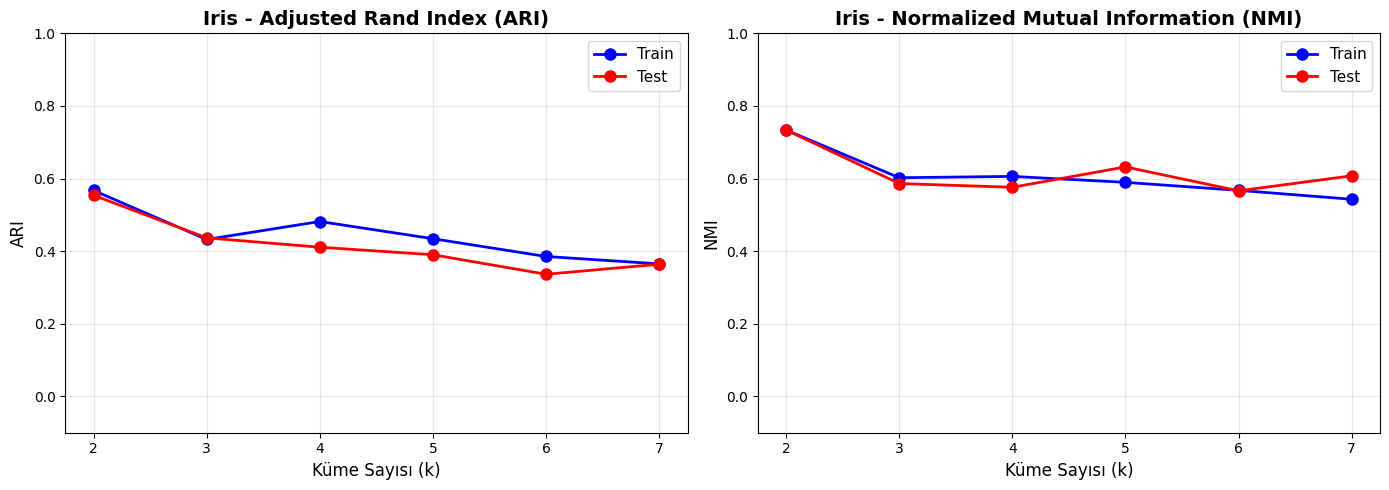

In [ ]:
# k = 2, ..., k_max için tüm değerlerin hesaplanması
k_values_iris = range(k_min_iris, k_max_iris + 1)

ari_train_values_iris = []
ari_test_values_iris = []
nmi_train_values_iris = []
nmi_test_values_iris = []

print("\n" + "=" * 50)
print("IRIS - ARI VE NMI ANALİZİ (Normalizasyonlu)")
print("=" * 50)

for k in k_values_iris:
    # K-Means eğitimi (train)
    labels_train_iris, centers_iris, inertia_iris = my_kmeans(X_iris_train_norm, k=k, random_state=42)

    # Test verisinin atanması
    labels_test_iris = assign_clusters(X_iris_test_norm, centers_iris)

    # ARI hesaplanması
    ari_train_iris = my_ari(y_iris_train, labels_train_iris)
    ari_test_iris = my_ari(y_iris_test, labels_test_iris)

    # NMI hesaplanması
    nmi_train_iris = normalized_mutual_info_score(y_iris_train, labels_train_iris)
    nmi_test_iris = normalized_mutual_info_score(y_iris_test, labels_test_iris)

    # Kaydedilmesi
    ari_train_values_iris.append(ari_train_iris)
    ari_test_values_iris.append(ari_test_iris)
    nmi_train_values_iris.append(nmi_train_iris)
    nmi_test_values_iris.append(nmi_test_iris)

    print(f"k={k} → ARI(train)={ari_train_iris:.4f}, ARI(test)={ari_test_iris:.4f}, "
          f"NMI(train)={nmi_train_iris:.4f}, NMI(test)={nmi_test_iris:.4f}")

print("=" * 50)

# Grafikleri çiz
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ARI grafiği
ax1.plot(k_values_iris, ari_train_values_iris, 'bo-', linewidth=2, markersize=8, label='Train')
ax1.plot(k_values_iris, ari_test_values_iris, 'ro-', linewidth=2, markersize=8, label='Test')
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('ARI', fontsize=12)
ax1.set_title('Iris - Adjusted Rand Index (ARI)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values_iris)
ax1.set_ylim([-0.1, 1.0])

# NMI grafiği
ax2.plot(k_values_iris, nmi_train_values_iris, 'bo-', linewidth=2, markersize=8, label='Train')
ax2.plot(k_values_iris, nmi_test_values_iris, 'ro-', linewidth=2, markersize=8, label='Test')
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('NMI', fontsize=12)
ax2.set_title('Iris - Normalized Mutual Information (NMI)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values_iris)
ax2.set_ylim([-0.1, 1.0])

plt.tight_layout()
plt.show()

## **WINE VE IRIS VERİ SETLERİ - KAPSAMLI KARŞILAŞTIRMA ANALİZİ**

### **Veri Seti Özellikleri**

| Özellik | Wine | Iris |
|:--------|:-----|:-----|
| **Örnek Sayısı** | 178 | 150 |
| **Öznitelik Sayısı** | 13 | 4 |
| **Sınıf Sayısı** | 3 | 3 |
| **Sınıf Dağılımı** | Dengesiz (59, 71, 48) | Dengeli (50, 50, 50) |
| **Öznitelik Ölçek Farkı** | ~2,600x | ~70x |
| **Sınıf Ayrılabilirliği** | Orta seviye | Bir sınıf net, iki sınıf iç içe |

---

### **İçsel Metrikler Karşılaştırması (Normalizasyonlu)**

#### **Elbow Metodu:**

| Veri Seti | k=2→3 Azalma | k=3→4 Azalma | Dirsek Noktası |
|:----------|:-------------|:-------------|:---------------|
| **Wine** | %23.5 | %5.8 | k=3 (DOĞRU) |
| **Iris** | %12.3 | %43.6 | k=3-4 arası (YANILTICI) |

**Yorum:** Wine'da dirsek noktası net k=3'ü işaret ediyor. Iris'te k=3→4 arası çok büyük düşüş var, bu yanıltıcı olabilir.

#### **Silhouette Skoru:**

| Veri Seti | k=2 | k=3 | k=4 | En Yüksek k |
|:----------|:----|:----|:----|:------------|
| **Wine** | 0.2670 | **0.2851** | 0.2266 | k=3 (DOĞRU) |
| **Iris** | **0.5759** | 0.4758 | 0.4201 | k=2 (YANLIŞ) |

**Yorum:** Wine için silhouette doğru k'yı buluyor. Iris için k=2 en yüksek skoru alıyor ama gerçek yapı k=3.

---

### **Dışsal Metrikler Karşılaştırması (Normalizasyonlu)**

#### **ARI (Adjusted Rand Index) - k=3 için:**

| Veri Seti | ARI (Train) | ARI (Test) | Kümeleme Kalitesi |
|:----------|:------------|:-----------|:------------------|
| **Wine** | **0.8511** | **0.9088** | Mükemmel |
| **Iris** | 0.4323 | 0.4367 | Orta |

#### **NMI (Normalized Mutual Information) - k=3 için:**

| Veri Seti | NMI (Train) | NMI (Test) | Bilgi Paylaşımı |
|:----------|:------------|:-----------|:----------------|
| **Wine** | **0.8359** | **0.9092** | Çok yüksek |
| **Iris** | 0.6023 | 0.5863 | Orta |

**Yorum:** Wine'da K-Means gerçek yapıyı çok iyi yakalıyor. Iris'te ise versicolor-virginica sınıfları iç içe geçtiği için başarı düşük.

---

### **Normalizasyonun Etkisi**

#### **Inertia Değişimi (k=3 için):**

| Veri Seti | Normalizasyonlu | Normalizasyonsuz | Oran |
|:----------|:----------------|:-----------------|:-----|
| **Wine** | 1,016 | 1,525,470 | **1,500x** (KRİTİK) |
| **Iris** | 159 | 120 | 0.75x (MINIMAL) |

**Yorum:** Wine'da normalizasyon kritik öneme sahip (yüksek fark). Iris'te öznitelikler zaten benzer ölçekte olduğu için etki ılımlı.

#### **Silhouette Değişimi (k=3 için):**

| Veri Seti | Normalizasyonlu | Normalizasyonsuz | Değişim |
|:----------|:----------------|:-----------------|:--------|
| **Wine** | 0.2851 | 0.5879 | +106% (YANILTICI) |
| **Iris** | 0.4758 | 0.5336 | +12% (MINIMAL) |

**Yorum:** Wine'da normalizasyon olmadan silhouette skoru yanıltıcı derecede yüksek. Iris'te fark minimal.

---

### **Optimal Küme Sayısı Belirleme Başarısı**

| Metrik Türü | Wine | Iris | Uyum |
|:------------|:-----|:-----|:-----|
| **Gerçek k** | 3 | 3 | - |
| **Elbow** | 3 (DOĞRU) | 3-4 arası (BELIRSIZ) | Kısmi |
| **Silhouette** | 3 (DOĞRU) | 2 (YANLIŞ) | Kısmi |
| **ARI** | 3 (DOĞRU) | 2 (YANLIŞ) | Kısmi |
| **NMI** | 3 (DOĞRU) | 2 (YANLIŞ) | Kısmi |

**Kritik Bulgu:** Metrikler Wine için %100 doğru, Iris için yanıltıcı.

---

### **Temel Çıkarımlar**

#### **1. Veri Seti Yapısının Önemi:**
- **Wine:** Sınıflar makul şekilde ayrılabilir, K-Means başarılı
- **Iris:** İki sınıf iç içe geçmiş, K-Means başarısız

#### **2. Normalizasyonun Kritik Rolü:**
- **Farklı ölçekli öznitelikler (Wine):** Normalizasyon ZORUNLU
- **Benzer ölçekli öznitelikler (Iris):** Normalizasyon ÖNERİLİR
- Normalizasyon olmadan metrikler yanıltıcı olabilir

#### **3. İçsel vs Dışsal Metrikler:**
- **İçsel metrikler** (Silhouette, Elbow) gerçek etiketsiz çalışır ama:
  - Wine'da doğru k'yı buldu
  - Iris'te yanlış k'yı önerdi
- **Dışsal metrikler** (ARI, NMI) gerçek etiketleri kullanır:
  - Kümeleme kalitesini objektif ölçer
  - Wine: Yüksek skor (başarılı kümeleme)
  - Iris: Düşük skor (doğal olarak zor)

#### **4. K-Means'in Sınırlamaları:**
- **Başarılı:** İyi ayrılmış, kaba küresel kümeler (Wine)
- **Başarısız:** İç içe geçmiş, doğrusal olmayan yapılar (Iris: versicolor-virginica)

---

### **Genel Sonuçlar ve Öneriler**

**Normalizasyon:**
- Her durumda uygulanmalı (tutarlılık için)
- Özellikle farklı birimli/ölçekli özniteliklerde kritik

**Metrik Seçimi:**
- Birden fazla metrik kullanılmalı
- İçsel + Dışsal metrikler birlikte değerlendirilmeli
- Sadece yüksek skor yeterli değil, gerçek yapı önemli

**K-Means Uygunluğu:**
- Veri setinin yapısına göre algoritma seçilmeli
- İyi ayrılmış kümeler için K-Means uygun
- İç içe geçmiş yapılar için başka algoritmalar denenebilir (DBSCAN, Hierarchical, GMM)

**Dikkat Edilmesi Gerekenler:**
- Metrikler her zaman doğru k'yı bulmayabilir (Iris örneği)
- Domain bilgisi ve görselleştirme önemli
- Gerçek etiketler varsa mutlaka dışsal metriklerle doğrulanmalı

---

### **Final Değerlendirme**

| Başarı Kriteri | Wine | Iris |
|:---------------|:-----|:-----|
| K-Means Uygunluğu | Çok Yüksek | Orta |
| Normalizasyon Etkisi | Kritik | Orta |
| Metrik Güvenilirliği | Yüksek | Düşük |
| Optimal k Bulma | Başarılı | Başarısız |
| Genel Kümeleme Kalitesi | Mükemmel (ARI: 0.85) | Orta (ARI: 0.43) |

**SONUÇ:** Bu çalışma, K-Means kümeleme algoritmasının performansının veri setinin doğal yapısına, öznitelik ölçeklerine ve sınıf ayrılabilirliğine bağlı olduğunu açıkça göstermiştir. Wine veri seti ideal bir K-Means senaryosuyken, Iris veri seti algoritmanın sınırlamalarını ortaya koymaktadır.
